# Dutch Corpora

Before running this notebook, install the `tempo-embeddings` package in your local environment:

```bash
pip install .
```

See [README.dev.md](../README.dev.md) for more details.

In [1]:
%load_ext autoreload

## Load Model

In [2]:
%autoreload now

LAYER=12

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
)

kwargs = {"accelerate": True}

# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

MODEL_NAME = "facebook/xmod-base"
kwargs["default_language"] = "nl_XX"
model_class = XModModelWrapper


# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)

Some weights of XmodModel were not initialized from the model checkpoint at facebook/xmod-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model._model.config

XmodConfig {
  "_name_or_path": "facebook/xmod-base",
  "adapter_layer_norm": false,
  "adapter_reduction_factor": 2,
  "adapter_reuse_layer_norm": true,
  "architectures": [
    "XmodForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "default_language": "nl_XX",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "languages": [
    "en_XX",
    "id_ID",
    "vi_VN",
    "ru_RU",
    "fa_IR",
    "sv_SE",
    "ja_XX",
    "fr_XX",
    "de_DE",
    "ro_RO",
    "ko_KR",
    "hu_HU",
    "es_XX",
    "fi_FI",
    "uk_UA",
    "da_DK",
    "pt_XX",
    "no_XX",
    "th_TH",
    "pl_PL",
    "bg_BG",
    "nl_XX",
    "zh_CN",
    "he_IL",
    "el_GR",
    "it_IT",
    "sk_SK",
    "hr_HR",
    "tr_TR",
    "ar_AR",
    "cs_CZ",
    "lt_LT",
    "hi_IN",
    "zh_TW",
    "ca_ES",
    "ms_MY",
    "sl_SI",
    "lv_LV",
    "ta_IN"

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

In [5]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 0
RANDOM_SAMPLE_STATEN_GENERAAL = 200

### ANP

In [6]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()

In [7]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


In [8]:
import random

random.seed(0)

files = random.sample(list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP)
files[:10]

[]

In [9]:
%autoreload now

import operator
from functools import reduce
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus


anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                model=model,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(files, unit="file")
        ),
    )
    if files
    else Corpus(model=model)
)

len(anp_corpus)

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour

0

### Staten Generaal

In [10]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert STATEN_GENERAAL_DIR.is_dir()

In [11]:
# files = random.sample(
#     list(STATEN_GENERAAL_DIR.glob("StatenGeneraal_????.csv.gz")),
#     k=RANDOM_SAMPLE_STATEN_GENERAAL,
# )

# glob = "StatenGeneraal_\(2???\|19\[5-9\]).csv.gz"
glob195x = "StatenGeneraal_19[5-9]?.csv.gz"
glob2000 = "StatenGeneraal_2???.csv.gz"
#files = list(STATEN_GENERAAL_DIR.glob(glob195x))
files = list(STATEN_GENERAAL_DIR.glob(glob2000))

files

[PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2003.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2011.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2013.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2001.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2005.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2009.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_2017.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal

In [12]:
import csv

csv.field_size_limit(100000000)

sg_corpus = reduce(
    operator.add,
    (
        Corpus.from_csv_file(
            path,
            model=model,
            text_columns=["Content"],
            encoding="utf-8",
            compression="gzip",
            delimiter=";",
            window_size=WINDOW_SIZE,
        )
        for path in tqdm(files, unit="file")
    )
    if files
    else Corpus(model=model),
)

len(sg_corpus)

  0%|          | 0/19 [00:00<?, ?file/s]

100%|██████████| 19/19 [00:14<00:00,  1.32file/s]


5065972

In [13]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

208 Passage('14de vergadering 2002-2003 14 14de vergadering Dinsdag 14 januari 2003 12.00 uur Voorzitter: Braks Tegenwoordig zijn 68 leden, te weten: Baarda, De Beer, Van de Beeten, Bemelmans-Videc, Van den Berg, Bierman,', {'': '107', 'RecId': 'h-ek-20022003-421-421', 'chamber': 'EersteKamer', 'date': '2003-01-14', 'speakers': 'no speakers', 'title': 'handelingen', 'year': '2003'}, None)
202 Passage('Bierman, De Blécourt-Maas, De Boer, Boorsma, Braks, Broekers-Knol, Van den Broek-Laman Trip, Van Bruchem, Castricum, Dees, Dölle, Dupuis, Van Eekelen, Eversdijk, Van Gennip, Ginjaar, Groen, Hessing, Van', {'': '107', 'RecId': 'h-ek-20022003-421-421', 'chamber': 'EersteKamer', 'date': '2003-01-14', 'speakers': 'no speakers', 'title': 'handelingen', 'year': '2003'}, None)
200 Passage('Van Heukelum, Hofstede, Holdijk, Van den Hul-Omta, Jaarsma, Jurgens, Ketting, Kneppers-Heijnert, Kohnstamm, Van der Lans, Van Leeuwen, Lemstra, Lodders-Elfferich, Luijten, Lycklama à Nijeholt, Maas-de', {'': '

### Merge

In [14]:
corpus = anp_corpus + sg_corpus
len(corpus)

5065972

## Compute Embeddings

In [15]:
TERM = "duurzaam"

In [16]:
%autoreload now

subcorpus = corpus.subcorpus(TERM, exact_match=False)
len(subcorpus)

13804

In [17]:
from tempo_embeddings.embeddings.model import EmbeddingsMethod

model.batch_size = 32
model.embeddings_method = EmbeddingsMethod.TOKEN
model.layer = 12

subcorpus.compute_embeddings()

Embeddings: 100%|██████████| 432/432 [01:41<00:00,  4.28batch/s]


## Read Stopwords

In [18]:
stopwords_file = (
    Path().absolute().parent / "tempo_embeddings" / "data" / "stopwords-filter-nl.txt"
)

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())
stopwords.update({"wij", "we", "moeten"})

In [19]:
#vectorizer = corpus.tfidf_vectorizer(stop_words=list(stopwords))

## Cluster

In [20]:
%autoreload now

from tempo_embeddings.text.cluster import Cluster

cluster = Cluster(subcorpus, vectorizer=None, n_topic_words=2)


In [21]:
cluster.cluster(stopwords=stopwords, min_cluster_size=10, cluster_selection_epsilon=0.2)

['minister; heer',
 'minister; wel',
 'duurzaamheid; heer',
 'duurzaamheid; ecologische',
 'opgewekte; volledig',
 '"duurzaam"; (duurzaam',
 '"duurzaam; minister',
 'geproduceerd; hout',
 'bouwen; gaat',
 'duurzaamheid; milieu',
 '"duurzaamheid"; begrip',
 'duurzaamheid; betrouwbaarheid',
 'duurzaamheid; heer',
 'monitor; nederland',
 'voedsel; vlees',
 'Outliers',
 'gas; productie',
 'hout; staatssecretaris',
 'bankieren; merkies',
 'verduurzaamd; gaat',
 'duurzaamste; europa',
 'onduurzaamheidsspiraal; onduurzaam']

# Visualize Embeddings

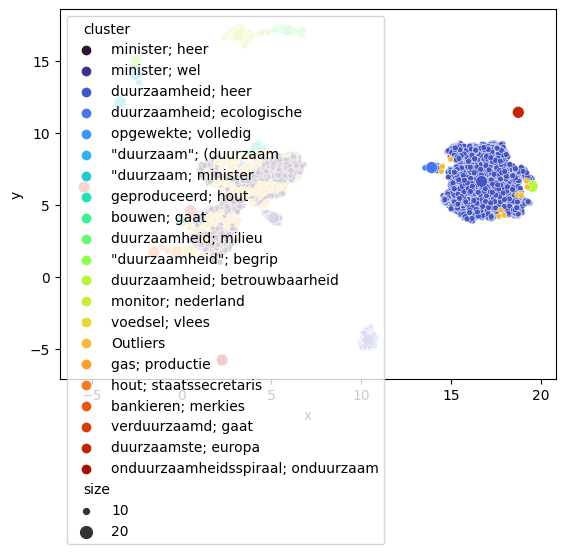

In [22]:
cluster.scatter_plot()

In [23]:
cluster.visualize()

### Refine sub-corpora

In [24]:
cluster.cluster_subcorpus("herstel_bezit", min_samples=8)

ValueError: Found 0 subcorpora with label 'herstel_bezit'.

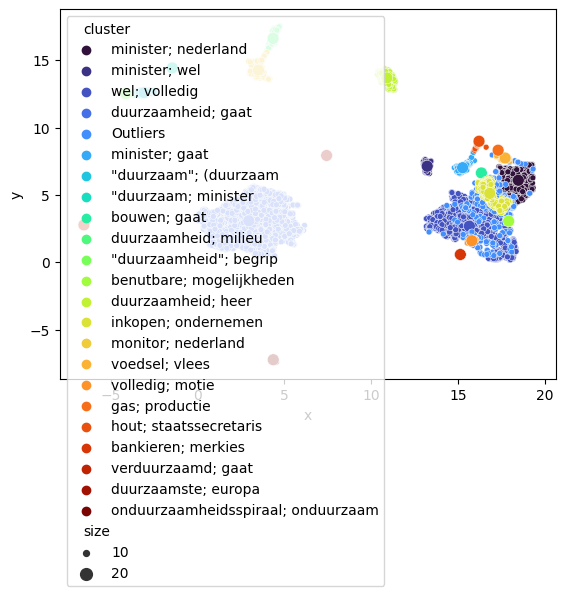

In [ ]:
cluster.scatter_plot()

In [ ]:
cluster.visualize()

In [ ]:
#cluster.merge("kunsthart_schipvoer", "bogers_dsm")


## Wizmap

In [ ]:
from tempo_embeddings.visualization.wizmap import WizmapVisualizer

port = 8000

if "wizmap_visualizer" in locals():
    # Cleanup previous run
    wizmap_visualizer.cleanup()


wizmap_visualizer = WizmapVisualizer(subcorpus, title=TERM, stopwords=stopwords)

wizmap_visualizer.visualize(port=port)

AttributeError: 'set' object has no attribute 'extend'

In [ ]:
if True:
    wizmap_visualizer.cleanup()